            user_id        item_id         rating     timestamp
count  100000.00000  100000.000000  100000.000000  1.000000e+05
mean      462.48475     425.530130       3.529860  8.835289e+08
std       266.61442     330.798356       1.125674  5.343856e+06
min         1.00000       1.000000       1.000000  8.747247e+08
25%       254.00000     175.000000       3.000000  8.794487e+08
50%       447.00000     322.000000       4.000000  8.828269e+08
75%       682.00000     631.000000       4.000000  8.882600e+08
max       943.00000    1682.000000       5.000000  8.932866e+08
Unique users: 943
Unique items: 1682


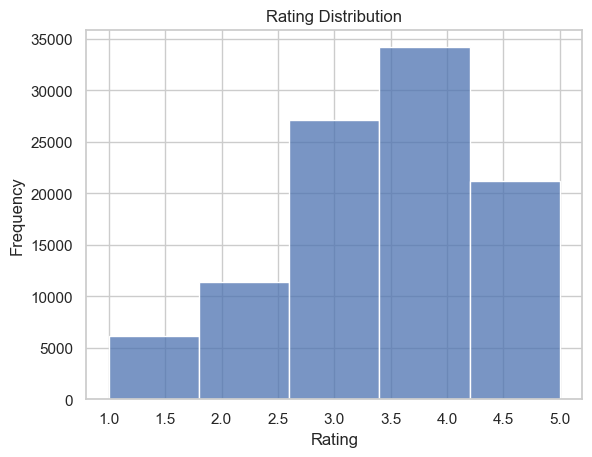

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load ratings data
ratings = pd.read_csv(r'C:\Users\ankis\Downloads\ak\ml-100k\u.data', sep='\t',
                      names=["user_id", "item_id", "rating", "timestamp"])

# Load movie metadata (u.item file)
movie_cols = ["movie_id", "title", "release_date", "video_release_date", "IMDb_URL",
              "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
              "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery",
              "Romance", "Sci-Fi", "Thriller", "War", "Western"]

movies = pd.read_csv(r'C:\Users\ankis\Downloads\ak\ml-100k\u.item', sep='|', encoding='latin-1',
                     header=None, names=movie_cols, usecols=range(len(movie_cols)))

# Clean data
ratings.dropna(inplace=True)
ratings['rating'] = ratings['rating'].astype(float)

# Exploratory Data Analysis
print(ratings.describe())
print('Unique users:', ratings['user_id'].nunique())
print('Unique items:', ratings['item_id'].nunique())

# Rating distribution plot
sns.set(style="whitegrid")
sns.histplot(ratings['rating'], bins=5, kde=False)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD

''' Load ratings'''
ratings = pd.read_csv(r'C:\Users\ankis\Downloads\ak\ml-100k\u.data', sep='\t',
                      names=['user_id', 'item_id', 'rating', 'timestamp'])

''' Create user-item matrix'''
user_item_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

''' Perform SVD'''
svd = TruncatedSVD(n_components=20, random_state=42)
matrix_reduced = svd.fit_transform(user_item_matrix)

''' Reconstruct full predicted ratings matrix'''
predicted_ratings = np.dot(matrix_reduced, svd.components_)
predicted_df = pd.DataFrame(predicted_ratings, index=user_item_matrix.index, columns=user_item_matrix.columns)

''' Recommend function for a user'''
def svd_recommend(user_id, top_n=5):
    user_row = predicted_df.loc[user_id]
    rated_items = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
    recommendations = user_row.drop(index=rated_items).sort_values(ascending=False).head(top_n)
    return recommendations.index.tolist()


In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

''' Load ratings'''
ratings = pd.read_csv(r'C:\Users\ankis\Downloads\ak\ml-100k\u.data', sep='\t',
                      names=['user_id', 'item_id', 'rating', 'timestamp'])

''' Create user-item matrix'''
user_item_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

''' Apply SVD'''
svd = TruncatedSVD(n_components=20, random_state=42)
matrix_reduced = svd.fit_transform(user_item_matrix)

''' Compute cosine similarity between users'''
user_similarity = cosine_similarity(matrix_reduced)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

''' Recommend items based on similar users'''
def get_user_based_recommendations(user_id, top_n=5):
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:top_n+1].index
    similar_users_ratings = user_item_matrix.loc[similar_users]
    mean_ratings = similar_users_ratings.mean(axis=0)
    user_seen_items = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
    recommendations = mean_ratings.drop(user_seen_items).sort_values(ascending=False).head(top_n)
    return recommendations

''' Example usage'''
print("Top 5 recommendations for user 1:")
print(get_user_based_recommendations(1))


Top 5 recommendations for user 1:
item_id
475    4.2
652    3.8
433    3.6
483    3.6
655    3.6
dtype: float64


In [4]:
def get_user_based_recommendations(user_id, top_n=5):
    # Step 1: Find similar users
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:top_n+1].index
    
    # Step 2: Get ratings from similar users
    similar_users_ratings = user_item_matrix.loc[similar_users]
    
    # Step 3: Get current user's ratings
    user_ratings = user_item_matrix.loc[user_id]
    
    # Step 4: Calculate weighted average scores
    weights = user_similarity_df[user_id][similar_users]
    weighted_ratings = similar_users_ratings.T.dot(weights)
    normalization = weights.sum()
    scores = weighted_ratings / normalization
    
    # Step 5: Recommend only unrated items
    unrated_items = user_ratings[user_ratings == 0].index
    recommendations = scores.loc[unrated_items].sort_values(ascending=False).head(top_n)
    
    return recommendations

''' Show recommendations with movie titles'''
recommended_ids = get_user_based_recommendations(1)
print("Top Recommendations for User 1:")
print(movies[movies.movie_id.isin(recommended_ids.index)][['movie_id', 'title']])


Top Recommendations for User 1:
     movie_id                                         title
432       433                               Heathers (1989)
474       475                          Trainspotting (1996)
482       483                             Casablanca (1942)
651       652  Rosencrantz and Guildenstern Are Dead (1990)
654       655                            Stand by Me (1986)


In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Define movie metadata column names
movie_columns = [
    "item_id", "title", "release_date", "video_release_date", "IMDb_URL",
    "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
    "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery",
    "Romance", "Sci-Fi", "Thriller", "War", "Western"
]

# Load movie metadata
movies = pd.read_csv(
    r'C:\Users\ankis\Downloads\ak\ml-100k\u.item',
    sep='|',
    encoding='latin-1',
    header=None,
    names=movie_columns
)

# Combine one-hot genre columns into a single genre string
genre_cols = movie_columns[5:]  # all genre columns start from index 5
movies['genres'] = movies[genre_cols].apply(
    lambda row: ' '.join([genre for genre, val in row.items() if val == 1]),
    axis=1
)

# Apply TF-IDF vectorizer to the combined genre strings
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(movies['genres'])

# Compute cosine similarity between movies
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Create a reverse lookup map from movie title to DataFrame index
indices = pd.Series(movies.index, index=movies['title'])

# Define the content-based recommendation function
def content_recommend(title, top_n=5):
    if title not in indices:
        return ["Movie not found."]
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    movie_indices = [i for i, _ in sim_scores]
    return movies['title'].iloc[movie_indices].tolist()

# Example usage
print("Content-based recommendations for 'Toy Story (1995)':")
print(content_recommend("Toy Story (1995)"))


Content-based recommendations for 'Toy Story (1995)':
['Aladdin and the King of Thieves (1996)', 'Aristocats, The (1970)', 'Pinocchio (1940)', 'Sword in the Stone, The (1963)', 'Fox and the Hound, The (1981)']


In [ ]:
# dashboard.py
import sys
print("Python Executable:", sys.executable)

import streamlit as st
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.decomposition import TruncatedSVD

# Load Movie Data
movie_columns = [
    "item_id", "title", "release_date", "video_release_date", "IMDb_URL",
    "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
    "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery",
    "Romance", "Sci-Fi", "Thriller", "War", "Western"
]

movies = pd.read_csv(
    r'C:\Users\ankis\Downloads\ak\ml-100k\u.item',
    sep='|', encoding='latin-1', header=None, names=movie_columns
)

ratings = pd.read_csv(
    r'C:\Users\ankis\Downloads\ak\ml-100k\u.data',
    sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp']
)

# --- Content-Based Filtering ---
genre_cols = movie_columns[5:]
movies['genres'] = movies[genre_cols].apply(
    lambda row: ' '.join([genre for genre, val in row.items() if val == 1]), axis=1
)

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(movies['genres'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(movies.index, index=movies['title'])

def content_recommend(title, top_n=5):
    if title not in indices:
        return ["Movie not found."]
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    movie_indices = [i for i, _ in sim_scores]
    return movies['title'].iloc[movie_indices].tolist()

# --- Collaborative Filtering using TruncatedSVD ---
user_item_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
svd = TruncatedSVD(n_components=20, random_state=42)
matrix_reduced = svd.fit_transform(user_item_matrix)
user_similarity = cosine_similarity(matrix_reduced)

user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

def svd_recommend(user_id, top_n=5):
    if user_id not in user_similarity_df.index:
        return ["Invalid User ID."]
    
    # Get similar users
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:6].index
    similar_ratings = user_item_matrix.loc[similar_users]
    weights = user_similarity_df[user_id][similar_users]
    
    weighted_ratings = similar_ratings.T.dot(weights)
    normalization = weights.sum()
    scores = weighted_ratings / normalization

    # Get items not already rated
    unrated_items = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] == 0].index
    recommendations = scores.loc[unrated_items].sort_values(ascending=False).head(top_n)
    return movies[movies['item_id'].isin(recommendations.index)]['title'].tolist()

# --- Streamlit Dashboard ---
st.title("🎬 Movie Recommendation System")

user_id = st.number_input("Enter your user ID (1–943):", min_value=1, max_value=943, value=1)
movie = st.selectbox("Choose a movie you like:", movies['title'])

st.write("### 📚 Content-based Recommendations")
for rec in content_recommend(movie):
    st.write("•", rec)

st.write("### 🤝 Collaborative Recommendations")
for rec in svd_recommend(user_id):
    st.write("•", rec)


Python Executable: c:\Users\ankis\personalised recomendation syatem\venv\Scripts\python.exe


ModuleNotFoundError: No module named 'surprise'

In [7]:
import sys
print("Python Executable:", sys.executable)


Python Executable: c:\Users\ankis\personalised recomendation syatem\venv\Scripts\python.exe
